In [1]:
# %%
# ============================================================================
# LAYER-WISE COMPRESSION IMPACT ANALYSIS
# Analyzing the individual impact of compressing different CNN layers
# ============================================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import copy
import time
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Set random seeds for reproducibility
set_all_seeds(42)

print("PyTorch version:", torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

PyTorch version: 2.5.1
Device: cuda


In [4]:
N_RANDOM_SEEDS = 10  # Number of random runs
CONFIDENCE_LEVEL = 0.95

In [5]:
# %%
# ============================================================================
# CORE FUNCTIONS
# ============================================================================

def algorithm_11_randomized_svd_power_iteration(A, k, q=2):
    """Algorithm 11: Randomized SVD with Power Iteration"""
    m, n = A.shape

    # Generate random matrix
    Omega = np.random.randn(n, 2 * k)

    # Power iteration
    Y = A @ Omega
    for _ in range(q):
        Y = A @ (A.T @ Y)

    # QR decomposition
    Q, R = np.linalg.qr(Y)

    # Project and compute SVD
    B = Q.T @ A
    U_tilde, Sigma, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde

    # Truncate to desired rank
    rank = min(k, len(Sigma))
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]

    return U, Sigma, Vt

def conv_to_matrix(weight, input_shape, stride=1, padding=0):
    """Convert convolutional layer to matrix form"""
    out_channels, in_channels, kh, kw = weight.shape
    weight_matrix = weight.view(out_channels, -1)
    return weight_matrix.cpu().numpy()

def linear_to_matrix(weight):
    """Convert linear layer to matrix form"""
    return weight.cpu().numpy()

class CompressedConv2D(nn.Module):
    """Compressed 2D Convolution using low-rank decomposition"""
    def __init__(self, U, S, Vt, original_shape, stride=1, padding=0, bias=None):
        super(CompressedConv2D, self).__init__()

        out_channels, in_channels, kh, kw = original_shape
        rank = len(S)

        self.original_shape = original_shape
        self.stride = stride
        self.padding = padding
        self.rank = rank

        # Two sequential conv layers for low-rank approximation
        self.conv1 = nn.Conv2d(in_channels, rank, kernel_size=(kh, kw),
                              stride=1, padding=padding, bias=False)
        self.conv2 = nn.Conv2d(rank, out_channels, kernel_size=1,
                              stride=stride, padding=0, bias=bias is not None)

        self._initialize_from_svd(U, S, Vt)

        if bias is not None:
            self.conv2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """Initialize using SVD components"""
        rank = len(S)
        out_channels, in_channels, kh, kw = self.original_shape

        # Reshape Vt for first conv layer
        V_reshaped = Vt.reshape(rank, in_channels, kh, kw)
        self.conv1.weight.data = torch.from_numpy(V_reshaped).float()

        # U and S for second conv layer
        US = U @ np.diag(S)
        self.conv2.weight.data = torch.from_numpy(US).float().unsqueeze(-1).unsqueeze(-1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class CompressedLinear(nn.Module):
    """Compressed Linear layer using low-rank decomposition"""
    def __init__(self, U, S, Vt, original_shape, bias=None):
        super(CompressedLinear, self).__init__()

        out_features, in_features = original_shape
        rank = len(S)

        self.original_shape = original_shape
        self.rank = rank

        # Two sequential linear layers for low-rank approximation
        self.linear1 = nn.Linear(in_features, rank, bias=False)
        self.linear2 = nn.Linear(rank, out_features, bias=bias is not None)

        self._initialize_from_svd(U, S, Vt)

        if bias is not None:
            self.linear2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """Initialize using SVD components"""
        # Vt for first linear layer
        self.linear1.weight.data = torch.from_numpy(Vt).float()

        # U and S for second linear layer
        US = U @ np.diag(S)
        self.linear2.weight.data = torch.from_numpy(US).float()

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class LayerAnalysisCNN(nn.Module):
    """CNN architecture for layer-wise compression analysis"""
    def __init__(self, num_classes=10):
        super(LayerAnalysisCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Store layer information for analysis
        self.layer_info = OrderedDict([
            ('conv1', {'layer': self.conv1, 'type': 'conv', 'position': 'early'}),
            ('conv2', {'layer': self.conv2, 'type': 'conv', 'position': 'early'}),
            ('conv3', {'layer': self.conv3, 'type': 'conv', 'position': 'middle'}),
            ('conv4', {'layer': self.conv4, 'type': 'conv', 'position': 'middle'}),
            ('fc1', {'layer': self.fc1, 'type': 'fc', 'position': 'late'}),
            ('fc2', {'layer': self.fc2, 'type': 'fc', 'position': 'late'}),
            ('fc3', {'layer': self.fc3, 'type': 'fc', 'position': 'final'})
        ])

    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [6]:
# %%
# ============================================================================
# DATA LOADING AND MODEL TRAINING
# ============================================================================

def load_datasets(batch_size=128):
    """Load both CIFAR-10 and CIFAR-100 datasets"""
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    
    # CIFAR-10
    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
    # CIFAR-100
    cifar100_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    
    datasets = {
        'CIFAR-10': (
            DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=2),
            DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)
        ),
        'CIFAR-100': (
            DataLoader(cifar100_train, batch_size=batch_size, shuffle=True, num_workers=2),
            DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=2)
        )
    }
    
    return datasets

def train_model(model, trainloader, testloader, epochs=15, lr=0.001):
    """Train the model"""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Evaluate
        test_acc = evaluate_model(model, testloader)
        best_acc = max(best_acc, test_acc)

        if epoch % 3 == 0:
            print(f"Epoch {epoch:2d}: Test Acc={test_acc:.2f}%")

    return model, best_acc

def evaluate_model(model, dataloader):
    """Evaluate model accuracy"""
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    return 100. * correct / total

In [7]:
# %%
# ============================================================================
# LAYER-WISE COMPRESSION ANALYSIS
# ============================================================================

def analyze_layer_spectrum(layer, layer_name):
    """Analyze the singular value spectrum of a layer"""
    weight = layer.weight.data

    if isinstance(layer, nn.Conv2d):
        W_matrix = conv_to_matrix(weight, (1, weight.shape[1], 32, 32))
    elif isinstance(layer, nn.Linear):
        W_matrix = linear_to_matrix(weight)
    else:
        return None

    # Compute SVD
    U, S, Vt = np.linalg.svd(W_matrix, full_matrices=False)

    # Calculate spectrum statistics
    energy_cumsum = np.cumsum(S**2) / np.sum(S**2)

    # Find ranks for different energy thresholds
    energy_ranks = {}
    for threshold in [0.7, 0.8, 0.9, 0.95, 0.99]:
        rank = np.argmax(energy_cumsum > threshold) + 1
        energy_ranks[threshold] = min(rank, len(S) - 1)

    return {
        'spectrum': S,
        'energy_ranks': energy_ranks,
        'condition_number': S[0] / S[-1] if S[-1] > 0 else float('inf'),
        'effective_rank': np.sum(S) / S[0] if S[0] > 0 else 0
    }

def compress_single_layer(model, layer_name, rank):
    """Compress a single layer in the model"""
    layer = getattr(model, layer_name)

    # Extract parameters
    weight = layer.weight.data
    bias = layer.bias.data if layer.bias is not None else None
    original_shape = weight.shape

    # Convert to matrix form
    if isinstance(layer, nn.Conv2d):
        W_matrix = conv_to_matrix(weight, (1, weight.shape[1], 32, 32))
        stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
        padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding
    elif isinstance(layer, nn.Linear):
        W_matrix = linear_to_matrix(weight)
        stride, padding = None, None
    else:
        raise ValueError(f"Unsupported layer type: {type(layer)}")

    # Ensure valid rank
    rank = min(rank, min(W_matrix.shape) - 1)

    # Apply randomized SVD
    U, S, Vt = algorithm_11_randomized_svd_power_iteration(W_matrix, rank, q=2)

    # Create compressed layer
    if isinstance(layer, nn.Conv2d):
        compressed_layer = CompressedConv2D(U, S, Vt, original_shape, stride, padding, bias)
    elif isinstance(layer, nn.Linear):
        compressed_layer = CompressedLinear(U, S, Vt, original_shape, bias)

    # Replace the layer
    setattr(model, layer_name, compressed_layer)

    # Calculate compression statistics
    original_params = weight.numel()
    compressed_params = U.size + S.size + Vt.size
    compression_ratio = original_params / compressed_params

    return compression_ratio

In [8]:
def fine_tune_compressed_model(model, trainloader, testloader, epochs=3, lr=0.0001):
    """Fine-tune compressed model and return final accuracy"""
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            if batch_idx > 15:  # Limit batches
                break
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
    
    return evaluate_model(model, testloader)

In [9]:
def layer_wise_compression_analysis_statistical(original_model, trainloader, testloader, dataset_name="CIFAR-10"):
    """Analyze with multiple random seeds for statistical rigor"""
    print("="*80)
    print(f"STATISTICAL LAYER-WISE COMPRESSION ANALYSIS - {dataset_name}")
    print("="*80)
    
    # Get baseline accuracy with multiple seeds
    baseline_accuracies = []
    for seed in range(N_RANDOM_SEEDS):
        torch.manual_seed(seed)
        np.random.seed(seed)
        acc = evaluate_model(original_model, testloader)
        baseline_accuracies.append(acc)
    
    baseline_mean = np.mean(baseline_accuracies)
    baseline_std = np.std(baseline_accuracies)
    baseline_ci = stats.t.interval(CONFIDENCE_LEVEL, len(baseline_accuracies)-1, 
                                  baseline_mean, stats.sem(baseline_accuracies))
    
    print(f"Baseline accuracy: {baseline_mean:.2f}±{baseline_std:.2f}% (95% CI: {baseline_ci[0]:.2f}-{baseline_ci[1]:.2f})")
    
    # Analyze layer spectra (once, deterministic)
    layer_spectra = {}
    normalized_sensitivities = {}
    
    for layer_name, layer_info in original_model.layer_info.items():
        spectrum_info = analyze_layer_spectrum(layer_info['layer'], layer_name)
        layer_spectra[layer_name] = spectrum_info
        
        # Calculate Frobenius norm for normalization
        weight = layer_info['layer'].weight.data
        if isinstance(layer_info['layer'], nn.Conv2d):
            W_matrix = conv_to_matrix(weight, (1, weight.shape[1], 32, 32))
        else:
            W_matrix = linear_to_matrix(weight)
        layer_spectra[layer_name]['frobenius_norm'] = np.linalg.norm(W_matrix, 'fro')
    
    # Statistical compression analysis
    compression_levels = [0.8, 0.9, 0.95]  # Reduced levels
    statistical_results = {}
    
    for compression_level in compression_levels:
        print(f"\n--- Testing {compression_level*100:.0f}% Energy Retention ---")
        statistical_results[compression_level] = {}
        
        for layer_name, layer_info in original_model.layer_info.items():
            print(f"Compressing {layer_name}...")
            
            layer_results = []
            
            # Multiple runs with different seeds
            for seed in range(N_RANDOM_SEEDS):
                torch.manual_seed(seed)
                np.random.seed(seed)
                
                num_classes = original_model.fc3.out_features
                model_copy = LayerAnalysisCNN(num_classes=num_classes)
                model_copy.load_state_dict(original_model.state_dict())
                
                rank = layer_spectra[layer_name]['energy_ranks'][compression_level]
                compression_ratio = compress_single_layer(model_copy, layer_name, rank)
                
                model_copy.to(device)
                acc_before = evaluate_model(model_copy, testloader)
                
                # Brief fine-tuning
                acc_after = fine_tune_compressed_model(model_copy, trainloader, testloader)
                
                layer_results.append({
                    'compression_ratio': compression_ratio,
                    'acc_before': acc_before,
                    'acc_after': acc_after,
                    'acc_drop_after': baseline_mean - acc_after,
                    'recovery': acc_after - acc_before
                })
            
            # Calculate statistics
            metrics = ['acc_before', 'acc_after', 'acc_drop_after', 'recovery']
            stats_dict = {}
            
            for metric in metrics:
                values = [result[metric] for result in layer_results]
                mean_val = np.mean(values)
                std_val = np.std(values)
                ci = stats.t.interval(CONFIDENCE_LEVEL, len(values)-1, mean_val, stats.sem(values))
                
                stats_dict[f'{metric}_mean'] = mean_val
                stats_dict[f'{metric}_std'] = std_val
                stats_dict[f'{metric}_ci'] = ci
            
            # Normalized sensitivity
            frobenius_norm = layer_spectra[layer_name]['frobenius_norm']
            stats_dict['normalized_sensitivity'] = stats_dict['acc_drop_after_mean'] / frobenius_norm
            
            stats_dict['rank'] = rank
            stats_dict['compression_ratio'] = layer_results[0]['compression_ratio']
            stats_dict['layer_type'] = layer_info['type']
            stats_dict['layer_position'] = layer_info['position']
            
            statistical_results[compression_level][layer_name] = stats_dict
            
            print(f"  Accuracy drop: {stats_dict['acc_drop_after_mean']:.2f}±{stats_dict['acc_drop_after_std']:.2f}%")
    
    return statistical_results, baseline_mean, baseline_std, layer_spectra

In [10]:
def create_individual_plots(results, baseline_mean, layer_spectra, dataset_name):
    """Create separate, focused plots"""
    plt.style.use('default')
    
    compression_levels = list(results.keys())
    layer_names = list(results[compression_levels[0]].keys())
    
    # Plot 1: Statistical Layer Sensitivity with Error Bars
    plt.figure(figsize=(12, 8))
    x = np.arange(len(layer_names))
    width = 0.25
    
    for i, comp_level in enumerate(compression_levels):
        means = [results[comp_level][layer]['acc_drop_after_mean'] for layer in layer_names]
        stds = [results[comp_level][layer]['acc_drop_after_std'] for layer in layer_names]
        
        plt.bar(x + i*width, means, width, yerr=stds, 
                label=f'{comp_level*100:.0f}% energy', alpha=0.8, capsize=5)
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Accuracy Drop (%)', fontsize=12)
    plt.title(f'Statistical Layer Sensitivity Analysis - {dataset_name}', fontsize=14)
    plt.xticks(x + width, layer_names, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Normalized Sensitivity Comparison
    plt.figure(figsize=(12, 8))
    
    # Use 90% compression for this analysis
    comp_level = 0.9
    norm_sensitivities = [results[comp_level][layer]['normalized_sensitivity'] for layer in layer_names]
    colors = ['red' if 'fc' in layer else 'blue' for layer in layer_names]
    
    bars = plt.bar(layer_names, norm_sensitivities, color=colors, alpha=0.7)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Normalized Sensitivity (Δ Acc / ||W||_F)', fontsize=12)
    plt.title(f'Normalized Layer Sensitivity - {dataset_name} (90% Energy)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, val in zip(bars, norm_sensitivities):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 3: Recovery Analysis with Confidence Intervals
    plt.figure(figsize=(12, 8))
    
    for comp_level in compression_levels:
        recoveries_mean = [results[comp_level][layer]['recovery_mean'] for layer in layer_names]
        recoveries_std = [results[comp_level][layer]['recovery_std'] for layer in layer_names]
        
        plt.errorbar(layer_names, recoveries_mean, yerr=recoveries_std, 
                    marker='o', label=f'{comp_level*100:.0f}% energy', 
                    linewidth=2, markersize=6, capsize=5)
    
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('Recovery (% points)', fontsize=12)
    plt.title(f'Fine-tuning Recovery Analysis - {dataset_name}', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:
def create_detailed_report(results, baseline_accuracy, layer_spectra):
    """Generate a detailed text report of the analysis"""
    print("\n" + "="*100)
    print("DETAILED LAYER-WISE COMPRESSION ANALYSIS REPORT")
    print("="*100)

    compression_levels = list(results.keys())
    layer_names = list(results[compression_levels[0]].keys())

    # Overall statistics
    print(f"\nBASELINE PERFORMANCE")
    print(f"Original model accuracy: {baseline_accuracy:.2f}%")
    print(f"Total layers analyzed: {len(layer_names)}")
    print(f"Compression levels tested: {[f'{cl*100:.0f}%' for cl in compression_levels]}")

    # Layer spectrum analysis
    print(f"\nLAYER SPECTRUM ANALYSIS")
    print("-" * 50)
    for layer_name in layer_names:
        spectrum_info = layer_spectra[layer_name]
        print(f"{layer_name:>8}: Condition={spectrum_info['condition_number']:>10.2e}, "
              f"Effective Rank={spectrum_info['effective_rank']:>8.1f}")

    # Layer sensitivity ranking
    print(f"\nLAYER SENSITIVITY RANKING")
    print("-" * 50)
    layer_criticality = {}
    for layer in layer_names:
        avg_sensitivity = np.mean([results[cl][layer]['acc_drop_after'] for cl in compression_levels])
        layer_criticality[layer] = avg_sensitivity

    sorted_layers = sorted(layer_criticality.items(), key=lambda x: x[1], reverse=True)

    for i, (layer, sensitivity) in enumerate(sorted_layers, 1):
        layer_info = results[compression_levels[0]][layer]
        print(f"{i:2d}. {layer:>8} ({layer_info['layer_type']:>4}, {layer_info['layer_position']:>6}): "
              f"{sensitivity:>6.2f}% avg drop")

    # Compression level analysis
    print(f"\nCOMPRESSION LEVEL ANALYSIS")
    print("-" * 50)
    for comp_level in compression_levels:
        avg_drop = np.mean([results[comp_level][layer]['acc_drop_after'] for layer in layer_names])
        avg_recovery = np.mean([results[comp_level][layer]['recovery'] for layer in layer_names])
        avg_compression = np.mean([results[comp_level][layer]['compression_ratio'] for layer in layer_names])

        print(f"{comp_level*100:>3.0f}% Energy Retention:")
        print(f"    Average accuracy drop: {avg_drop:>6.2f}%")
        print(f"    Average recovery:      {avg_recovery:>6.2f}%")
        print(f"    Average compression:   {avg_compression:>6.2f}x")
        print()

    # Layer type analysis
    print(f"LAYER TYPE ANALYSIS")
    print("-" * 50)
    conv_layers = [l for l in layer_names if 'conv' in l]
    fc_layers = [l for l in layer_names if 'fc' in l]

    for comp_level in compression_levels:
        conv_avg = np.mean([results[comp_level][layer]['acc_drop_after'] for layer in conv_layers])
        fc_avg = np.mean([results[comp_level][layer]['acc_drop_after'] for layer in fc_layers])

        print(f"{comp_level*100:>3.0f}% Energy - Conv: {conv_avg:>6.2f}%, FC: {fc_avg:>6.2f}%")

    # Detailed layer-by-layer results
    print(f"\nDETAILED LAYER-BY-LAYER RESULTS")
    print("-" * 100)

    for layer_name in layer_names:
        print(f"\n{layer_name.upper()} LAYER:")
        print(f"{'Compression':>12} {'Rank':>6} {'Ratio':>8} {'Acc Before':>12} {'Acc After':>11} {'Drop':>8} {'Recovery':>10}")
        print("-" * 80)

        for comp_level in compression_levels:
            result = results[comp_level][layer_name]
            print(f"{comp_level*100:>10.0f}% {result['rank']:>6} {result['compression_ratio']:>8.2f}x "
                  f"{result['acc_before']:>10.2f}% {result['acc_after']:>10.2f}% "
                  f"{result['acc_drop_after']:>7.2f}% {result['recovery']:>9.2f}%")

    # Key findings
    print(f"\nKEY FINDINGS")
    print("-" * 50)

    most_critical = sorted_layers[0][0]
    least_critical = sorted_layers[-1][0]

    print(f"• Most critical layer: {most_critical} ({sorted_layers[0][1]:.2f}% avg drop)")
    print(f"• Least critical layer: {least_critical} ({sorted_layers[-1][1]:.2f}% avg drop)")

    # Best compression strategy
    best_level = min(compression_levels, key=lambda x: np.mean([results[x][l]['acc_drop_after'] for l in layer_names]))
    print(f"• Best overall compression level: {best_level*100:.0f}% energy retention")

    # Layer position insights
    position_analysis = {}
    for position in ['early', 'middle', 'late', 'final']:
        position_layers = [l for l in layer_names if results[compression_levels[0]][l]['layer_position'] == position]
        if position_layers:
            avg_sensitivity = np.mean([layer_criticality[l] for l in position_layers])
            position_analysis[position] = avg_sensitivity

    print(f"• Layer position sensitivity: {dict(sorted(position_analysis.items(), key=lambda x: x[1]))}")

    # Recovery analysis
    best_recovery_layer = max(layer_names, key=lambda x: np.mean([results[cl][x]['recovery'] for cl in compression_levels]))
    print(f"• Best recovery with fine-tuning: {best_recovery_layer}")

    print("\n" + "="*100)

In [12]:
def generate_statistical_report(results, baseline_mean, baseline_std, dataset_name):
    """Generate statistical report with confidence intervals"""
    print(f"\nSTATISTICAL ANALYSIS REPORT - {dataset_name}")
    print("="*60)
    print(f"Baseline: {baseline_mean:.2f}±{baseline_std:.2f}%")
    
    # Most statistically significant layers
    layer_sensitivities = []
    for comp_level in results.keys():
        for layer_name, layer_result in results[comp_level].items():
            sensitivity = layer_result['acc_drop_after_mean']
            std_err = layer_result['acc_drop_after_std'] / np.sqrt(N_RANDOM_SEEDS)
            t_stat = sensitivity / std_err if std_err > 0 else 0
            
            layer_sensitivities.append((layer_name, sensitivity, t_stat))
    
    # Sort by statistical significance (t-statistic)
    layer_sensitivities.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\nMost Statistically Significant Layers:")
    for i, (layer, sens, t_stat) in enumerate(layer_sensitivities[:5], 1):
        print(f"{i}. {layer}: {sens:.2f}% drop (t={t_stat:.2f})")

def compare_datasets(all_results):
    """Compare results across datasets"""
    print(f"\nCROSS-DATASET COMPARISON")
    print("="*60)
    
    for layer_name in ['conv1', 'conv4', 'fc1', 'fc3']:
        cifar10_sens = all_results['CIFAR-10']['results'][0.9][layer_name]['acc_drop_after_mean']
        cifar100_sens = all_results['CIFAR-100']['results'][0.9][layer_name]['acc_drop_after_mean']
        
        print(f"{layer_name}: CIFAR-10={cifar10_sens:.2f}%, CIFAR-100={cifar100_sens:.2f}%")

In [13]:
# %%
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution with both datasets"""
    set_all_seeds(42)
    print("Starting Statistical Layer-wise Compression Analysis...")
    
    # Load datasets
    datasets = load_datasets(batch_size=128)
    
    all_results = {}
    
    for dataset_name, (trainloader, testloader) in datasets.items():
        print(f"\n{'='*60}")
        print(f"ANALYZING {dataset_name}")
        print(f"{'='*60}")
        
        # Create and train model
        num_classes = 10 if dataset_name == 'CIFAR-10' else 100
        model = LayerAnalysisCNN(num_classes=num_classes)
        
        epochs = 12 if dataset_name == 'CIFAR-10' else 20
        model, best_acc = train_model(model, trainloader, testloader, epochs=epochs)
        
        print(f"Model training completed. Best accuracy: {best_acc:.2f}%")
        
        # Statistical analysis
        results, baseline_mean, baseline_std, layer_spectra = layer_wise_compression_analysis_statistical(
            model, trainloader, testloader, dataset_name)
        
        # Store results
        all_results[dataset_name] = {
            'results': results,
            'baseline_mean': baseline_mean,
            'baseline_std': baseline_std,
            'layer_spectra': layer_spectra
        }
        
        # Create visualizations
        create_individual_plots(results, baseline_mean, layer_spectra, dataset_name)
        
        # Generate statistical report
        generate_statistical_report(results, baseline_mean, baseline_std, dataset_name)
    
    # Cross-dataset comparison
    compare_datasets(all_results)
    
    return all_results

In [14]:
# %%
# ============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# ============================================================================

def compare_compression_strategies(all_results):
    """Compare different compression strategies across datasets"""
    for dataset_name, dataset_results in all_results.items():
        print(f"\n{'='*80}")
        print(f"COMPRESSION STRATEGY COMPARISON - {dataset_name}")
        print(f"{'='*80}")
        
        results = dataset_results['results']
        baseline_accuracy = dataset_results['baseline_mean']
        
        compression_levels = list(results.keys())
        layer_names = list(results[compression_levels[0]].keys())

        # Strategy 1: Uniform Compression
        print("\nStrategy 1: Uniform Compression")
        print("-" * 40)
        for comp_level in compression_levels:
            total_drop = sum([results[comp_level][layer]['acc_drop_after_mean'] for layer in layer_names])
            avg_drop = total_drop / len(layer_names)
            print(f"{comp_level*100:>3.0f}% Energy: {avg_drop:>6.2f}% avg drop per layer")

        # Strategy 2: Compress only robust layers
        print("\nStrategy 2: Selective Compression (Robust Layers Only)")
        print("-" * 40)

        # Identify robust layers (bottom 50% in sensitivity)
        layer_criticality = {}
        for layer in layer_names:
            avg_sensitivity = np.mean([results[cl][layer]['acc_drop_after_mean'] for cl in compression_levels])
            layer_criticality[layer] = avg_sensitivity

        sorted_layers = sorted(layer_criticality.items(), key=lambda x: x[1])
        robust_layers = [layer for layer, _ in sorted_layers[:len(sorted_layers)//2]]

        print(f"Robust layers identified: {robust_layers}")
        for comp_level in compression_levels:
            avg_drop = np.mean([results[comp_level][layer]['acc_drop_after_mean'] for layer in robust_layers])
            print(f"{comp_level*100:>3.0f}% Energy: {avg_drop:>6.2f}% avg drop (robust layers only)")

        # Strategy 3: Avoid critical layers
        print("\nStrategy 3: Avoid Critical Layers")
        print("-" * 40)
        critical_layers = [layer for layer, _ in sorted_layers[-2:]]
        safe_layers = [layer for layer in layer_names if layer not in critical_layers]

        print(f"Critical layers to avoid: {critical_layers}")
        print(f"Safe layers to compress: {safe_layers}")
        for comp_level in compression_levels:
            avg_drop = np.mean([results[comp_level][layer]['acc_drop_after_mean'] for layer in safe_layers])
            print(f"{comp_level*100:>3.0f}% Energy: {avg_drop:>6.2f}% avg drop (safe layers only)")

Starting Statistical Layer-wise Compression Analysis...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified

ANALYZING CIFAR-10
Epoch  0: Test Acc=50.70%
Epoch  3: Test Acc=73.00%
Epoch  6: Test Acc=76.55%
Epoch  9: Test Acc=79.54%
Model training completed. Best accuracy: 79.99%
STATISTICAL LAYER-WISE COMPRESSION ANALYSIS - CIFAR-10
Baseline accuracy: 79.53±0.00% (95% CI: nan-nan)

--- Testing 80% Energy Retention ---
Compressing conv1...
  Accuracy drop: 1.51±0.17%
Compressing conv2...
  Accuracy drop: -1.70±0.17%
Compressing conv3...
  Accuracy drop: -1.63±0.19%
Compressing conv4...
  Accuracy drop: -1.81±0.21%
Compressing fc1...
  Accuracy drop: -2.08±0.10%
Compressing fc2...
  Accuracy drop: -2.07±0.12%
Compressing fc3...
  Accuracy drop: 0.00±0.20%

--- Testing 90% Energy Retention ---
Compressing conv1...
  Accuracy drop: 0.44±0.15%
Compressing conv2...
  Accuracy drop: -2.01±0.15%

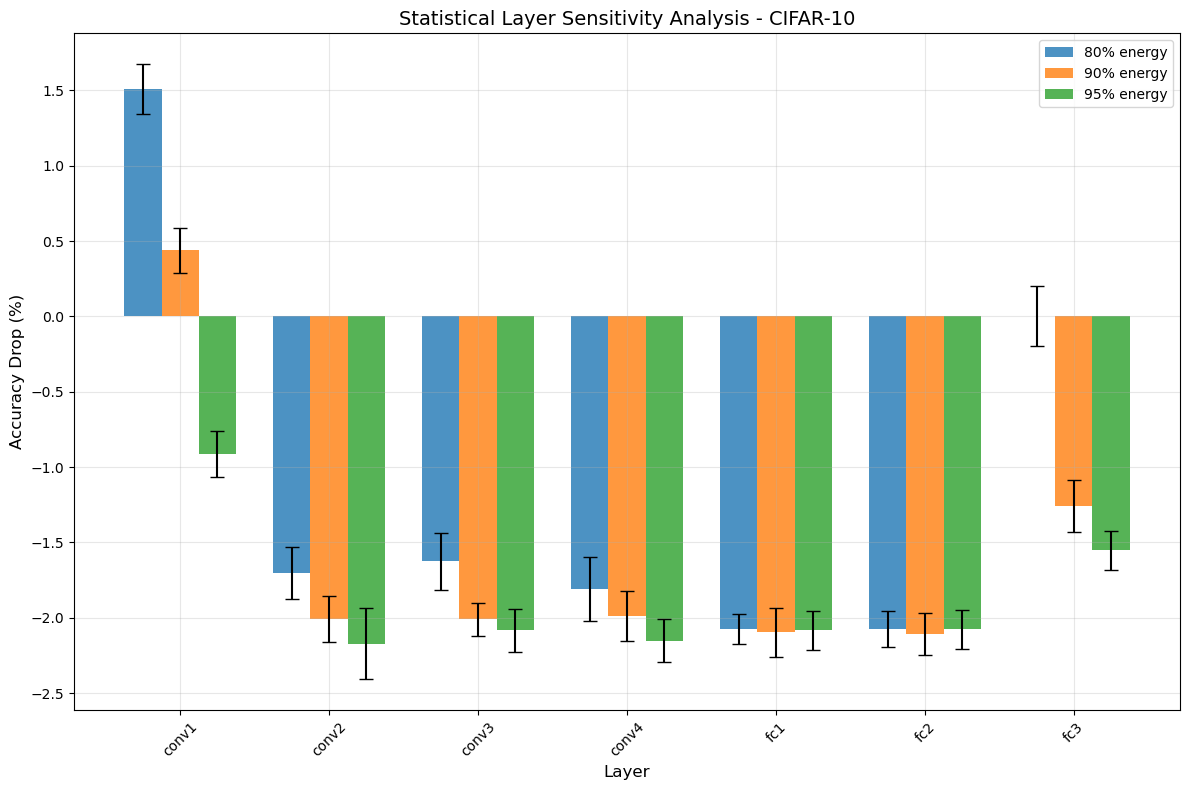

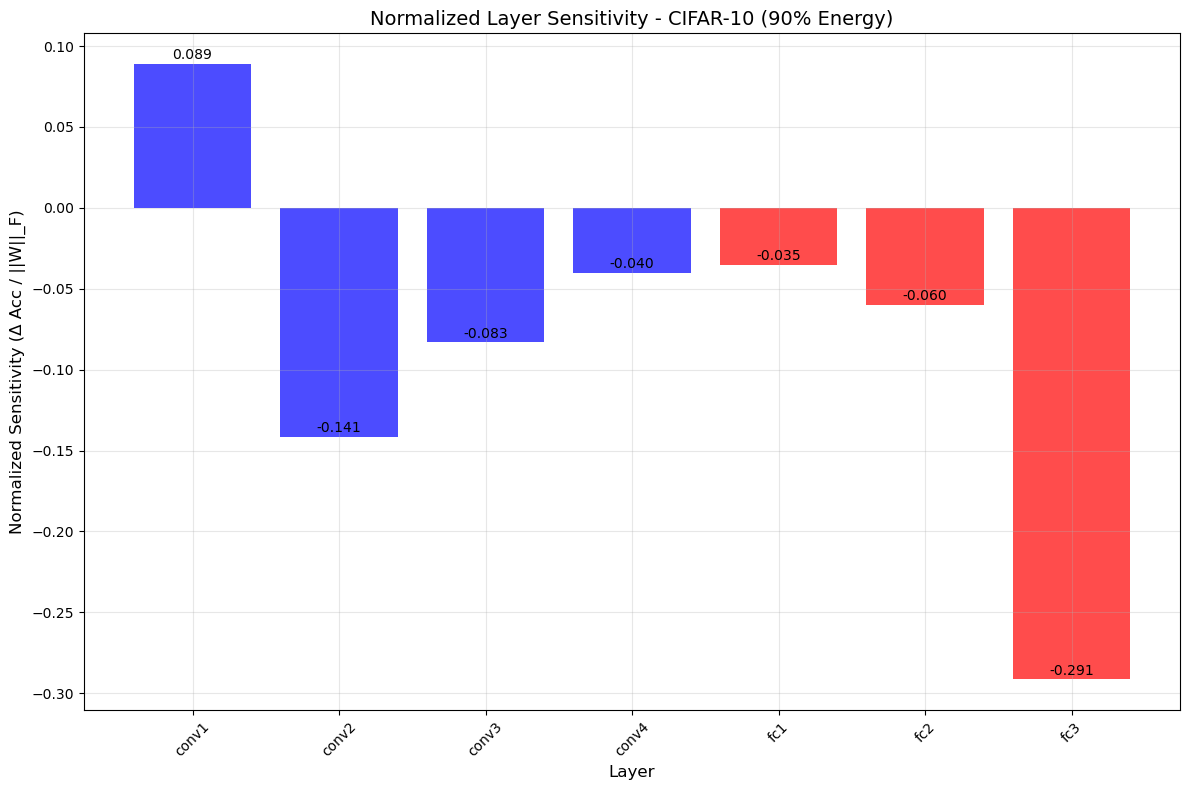

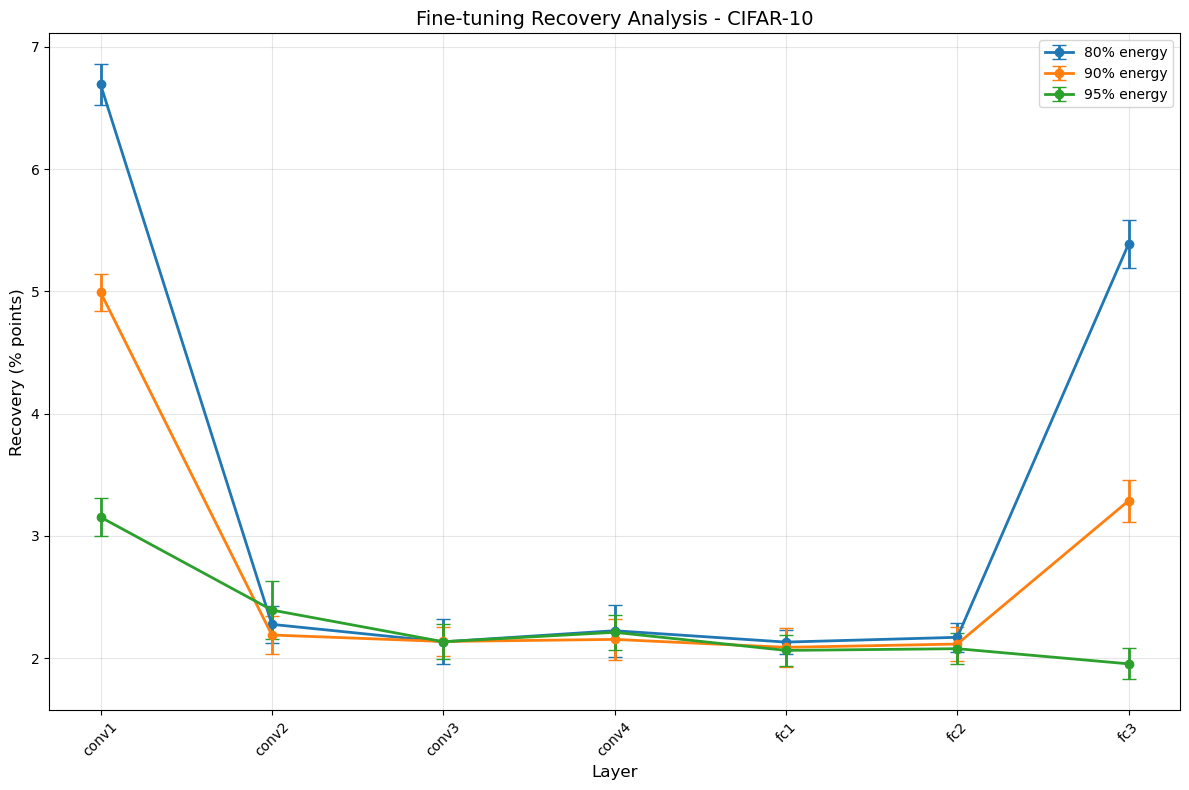


STATISTICAL ANALYSIS REPORT - CIFAR-10
Baseline: 79.53±0.00%

Most Statistically Significant Layers:
1. conv1: 1.51% drop (t=28.58)
2. conv1: 0.44% drop (t=9.10)
3. fc3: 0.00% drop (t=0.03)
4. conv1: -0.91% drop (t=-18.71)
5. fc3: -1.26% drop (t=-22.87)

ANALYZING CIFAR-100
Epoch  0: Test Acc=9.88%
Epoch  3: Test Acc=25.54%
Epoch  6: Test Acc=33.53%
Epoch  9: Test Acc=36.97%
Epoch 12: Test Acc=40.34%
Epoch 15: Test Acc=41.24%
Epoch 18: Test Acc=43.03%
Model training completed. Best accuracy: 43.59%
STATISTICAL LAYER-WISE COMPRESSION ANALYSIS - CIFAR-100
Baseline accuracy: 43.59±0.00% (95% CI: 43.59-43.59)

--- Testing 80% Energy Retention ---
Compressing conv1...
  Accuracy drop: 7.39±0.20%
Compressing conv2...
  Accuracy drop: -1.58±0.14%
Compressing conv3...
  Accuracy drop: -1.25±0.19%
Compressing conv4...
  Accuracy drop: -0.98±0.20%
Compressing fc1...
  Accuracy drop: -1.54±0.10%
Compressing fc2...
  Accuracy drop: -1.45±0.16%
Compressing fc3...
  Accuracy drop: 2.24±0.26%

--- T

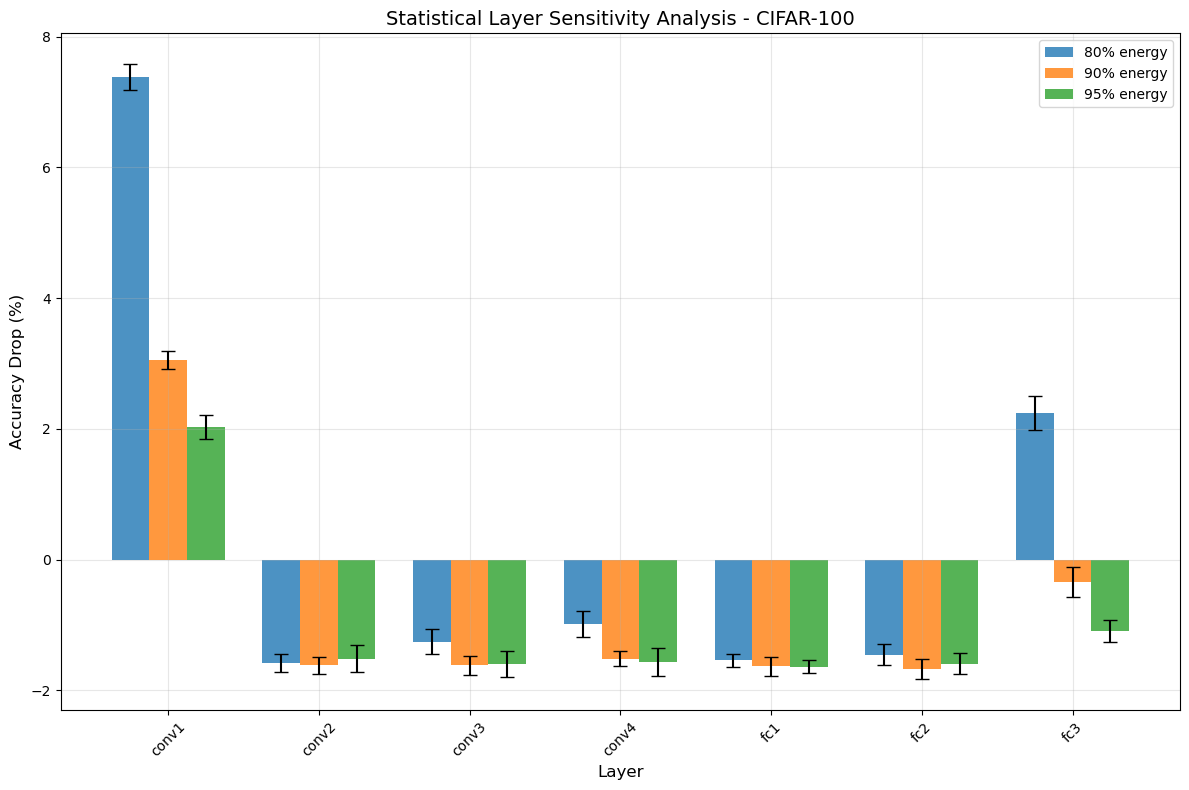

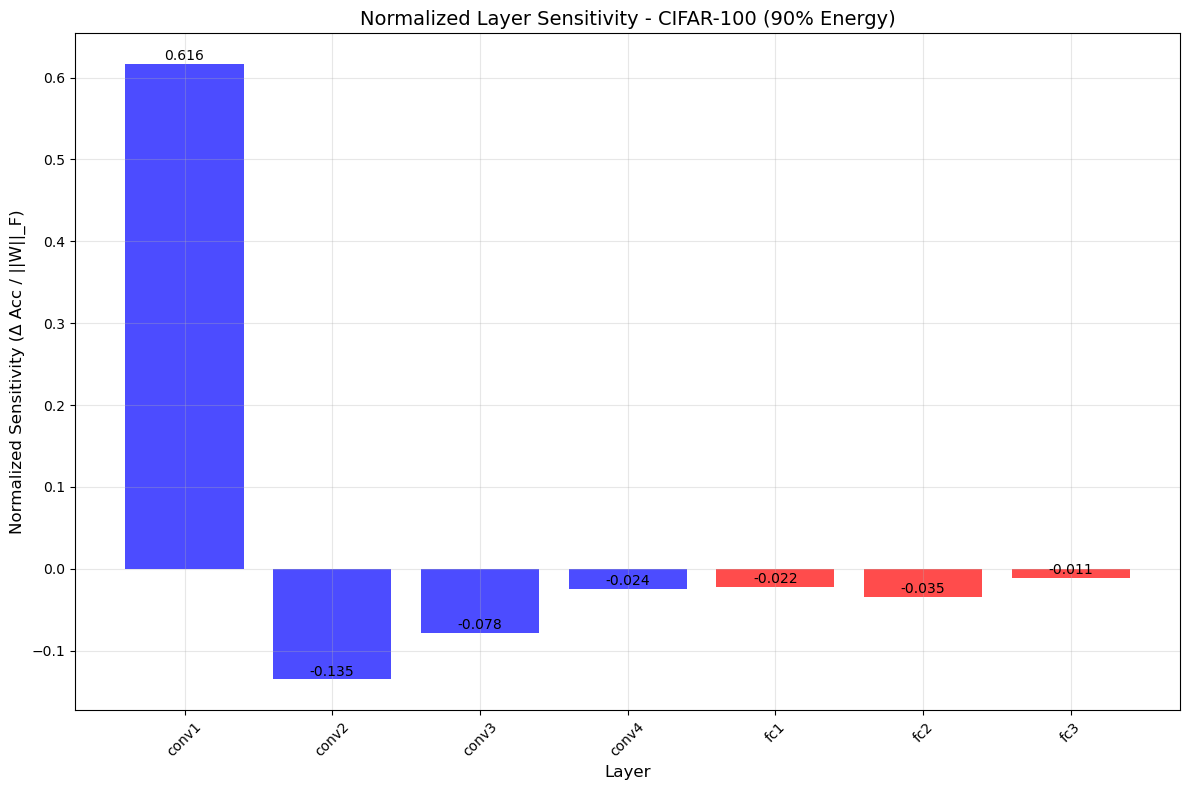

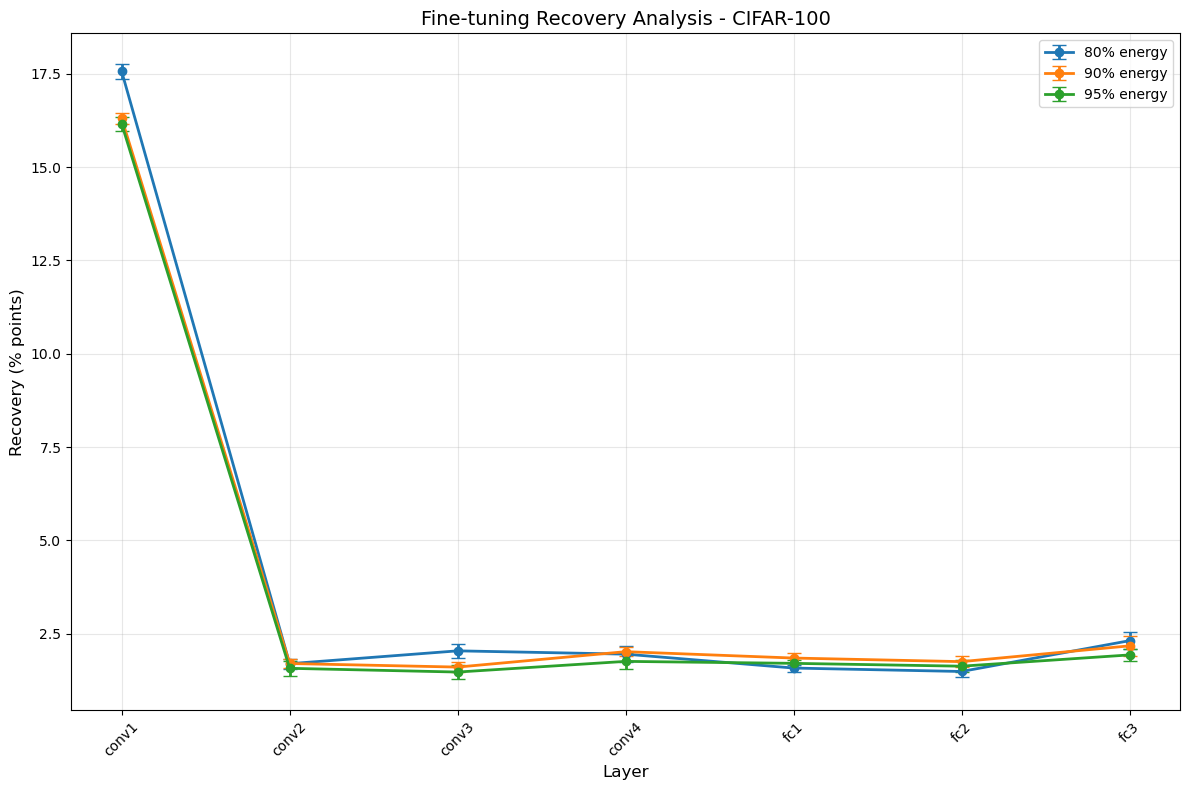


STATISTICAL ANALYSIS REPORT - CIFAR-100
Baseline: 43.59±0.00%

Most Statistically Significant Layers:
1. conv1: 7.39% drop (t=119.01)
2. conv1: 3.05% drop (t=68.53)
3. conv1: 2.03% drop (t=35.64)
4. fc3: 2.24% drop (t=27.20)
5. fc3: -0.34% drop (t=-4.80)

CROSS-DATASET COMPARISON
conv1: CIFAR-10=0.44%, CIFAR-100=3.05%
conv4: CIFAR-10=-1.98%, CIFAR-100=-1.52%
fc1: CIFAR-10=-2.10%, CIFAR-100=-1.63%
fc3: CIFAR-10=-1.26%, CIFAR-100=-0.34%

COMPRESSION STRATEGY COMPARISON - CIFAR-10

Strategy 1: Uniform Compression
----------------------------------------
 80% Energy:  -1.11% avg drop per layer
 90% Energy:  -1.57% avg drop per layer
 95% Energy:  -1.86% avg drop per layer

Strategy 2: Selective Compression (Robust Layers Only)
----------------------------------------
Robust layers identified: ['fc2', 'fc1', 'conv4']
 80% Energy:  -1.99% avg drop (robust layers only)
 90% Energy:  -2.06% avg drop (robust layers only)
 95% Energy:  -2.10% avg drop (robust layers only)

Strategy 3: Avoid Cri

In [15]:
if __name__ == "__main__":
    # Run the main analysis
    all_results = main()

    # Additional analyses
    compare_compression_strategies(all_results)

    print("\n" + "="*80)
    print("LAYER-WISE COMPRESSION ANALYSIS COMPLETED")
    print("="*80)